# Segmenting malaria cells using annotated bounded box

In [4]:
!pip install opencv-python matplotlib onnx onnxruntime
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kc2ab27k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kc2ab27k
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl

In [26]:
import torch
import torchvision
import sys
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic
import os
import json
import numpy as np

Mount drive

In [136]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Helper functions

In [83]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

SAM ONNX setup

In [57]:
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint)

import warnings

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )    


onnx_model_quantized_path = "sam_onnx_quantized_example.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]

Get malaria dataset images

In [21]:
data = []

for filename in os.listdir("/content/drive/MyDrive/malaria_dataset/malaria/images"):
    if filename.endswith("png") or filename.endswith("jpg"): 
        
        data.append(filename)


#testing, do first 100
data = data[:100]
print(len(data))

100


Get JSON file annotations

In [44]:
with open('/content/drive/MyDrive/malaria_dataset/malaria/training.json') as json_file:
    malaria_annotations = json.load(json_file)


In [59]:
image = cv2.imread(f'/content/drive/MyDrive/malaria_dataset/malaria/images/{data[2]}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [60]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)
sam.to(device='cuda')
predictor = SamPredictor(sam)
predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()

In [62]:
#find the right annotation
annotation =[]
for i in malaria_annotations:
    if data[2] in i["image"]["pathname"]:
        annotation.append(i)
        break

print(annotation)

[{'image': {'checksum': '058d853df80d5207a08972b9658bd8f4', 'pathname': '/images/42845335-4ab2-4963-806d-0985d1382a31.png', 'shape': {'r': 1200, 'c': 1600, 'channels': 3}}, 'objects': [{'bounding_box': {'minimum': {'r': 629, 'c': 321}, 'maximum': {'r': 725, 'c': 423}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 363, 'c': 332}, 'maximum': {'r': 470, 'c': 451}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 200, 'c': 1014}, 'maximum': {'r': 303, 'c': 1114}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 1050, 'c': 1349}, 'maximum': {'r': 1144, 'c': 1447}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 352, 'c': 1152}, 'maximum': {'r': 460, 'c': 1260}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 255, 'c': 848}, 'maximum': {'r': 349, 'c': 960}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 967, 'c': 120}, 'maximum': {'r': 1094, 'c': 245}}, 'category': 'red blood ce

Highlight bounded boxes for non red blood cells

In [116]:
#get non red blood cells (abnormalities)

non_red_blood_cell_boxes = [i["bounding_box"] for i in annotation[0]["objects"] if i["category"] != 'red blood cell']

print("for this image, these are the annotations of non red blood cells")
input_box = []
for i in non_red_blood_cell_boxes:
    input_box.append([i["minimum"]["c"] ,i["minimum"]["r"], i["maximum"]["c"],i["maximum"]["r"]])
    print(i)
    


input_box = input_box #(min c, min r, max c, max r)
input_point = np.array([[0,0]])
input_label = np.array([0])

for this image, these are the annotations of non red blood cells
{'minimum': {'r': 117, 'c': 60}, 'maximum': {'r': 249, 'c': 182}}
{'minimum': {'r': 809, 'c': 24}, 'maximum': {'r': 962, 'c': 178}}
{'minimum': {'r': 113, 'c': 359}, 'maximum': {'r': 263, 'c': 501}}


In [122]:
#preprocess coordinated for multiple boxes
ALL_MASKS = []
print(input_box)
for i in input_box:
    i = np.array(i)
    onnx_box_coords = i.reshape(2, 2)
    onnx_box_labels = np.array([2,3])

    onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
    onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

    onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
    onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
    onnx_has_mask_input = np.zeros(1, dtype=np.float32)

    ort_inputs = {
        "image_embeddings": image_embedding,
        "point_coords": onnx_coord,
        "point_labels": onnx_label,
        "mask_input": onnx_mask_input,
        "has_mask_input": onnx_has_mask_input,
        "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
    }

    masks, _, _ = ort_session.run(None, ort_inputs)
    masks = masks > predictor.model.mask_threshold
    ALL_MASKS.append(masks[0])

[[60, 117, 182, 249], [24, 809, 178, 962], [359, 113, 501, 263]]


3


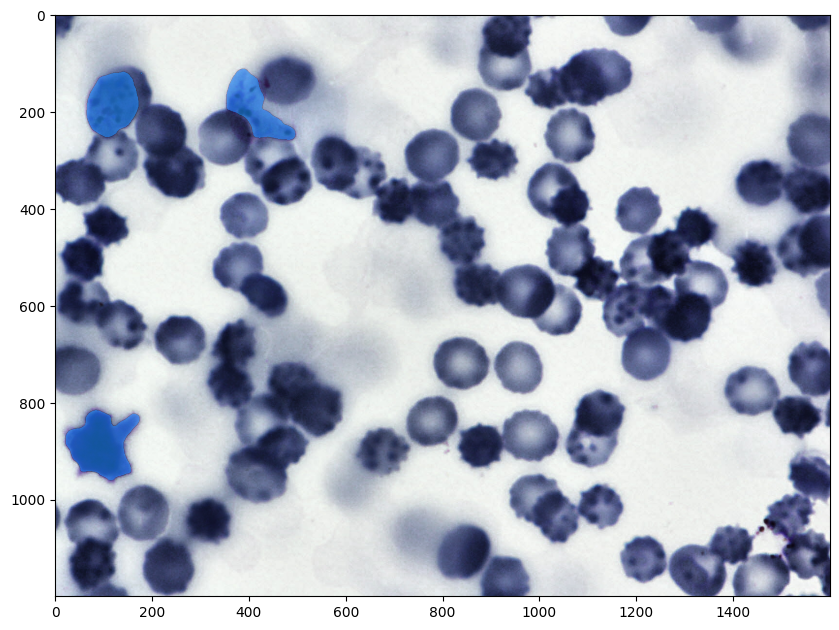

In [135]:
print(len(ALL_MASKS))
plt.figure(figsize=(10, 10))
plt.imshow(image)
ALL_MASKS = np.array(ALL_MASKS)
result = np.logical_or.reduce(ALL_MASKS, axis=0)

show_mask(result, plt.gca())

DO THIS FOR ALL IMAGES

In [157]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)
sam.to(device='cuda')
predictor = SamPredictor(sam)
batch_segments ={}
count = 0
for img in data:
    image = cv2.imread(f'/content/drive/MyDrive/malaria_dataset/malaria/images/{img}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

 
    predictor.set_image(image)
    image_embedding = predictor.get_image_embedding().cpu().numpy()

    #find the right annotation
    annotation =[]
    for x in malaria_annotations:
        if img in x["image"]["pathname"]:
            annotation.append(x)
            break
    if annotation == []:
        continue
    non_red_blood_cell_boxes = [item["bounding_box"] for item in annotation[0]["objects"] if item["category"] != 'red blood cell']

    print("for this image, these are the annotations of non red blood cells")
    input_box = []
    for y in non_red_blood_cell_boxes:
        input_box.append([y["minimum"]["c"] ,y["minimum"]["r"], y["maximum"]["c"],y["maximum"]["r"]])
        
    input_box = input_box #(min c, min r, max c, max r)
    input_point = np.array([[0,0]])
    input_label = np.array([0])


    ALL_MASKS = []
    print(input_box)
    for i in input_box:
        i = np.array(i)
        onnx_box_coords = i.reshape(2, 2)
        onnx_box_labels = np.array([2,3])

        onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
        onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

        onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
        onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
        onnx_has_mask_input = np.zeros(1, dtype=np.float32)

        ort_inputs = {
            "image_embeddings": image_embedding,
            "point_coords": onnx_coord,
            "point_labels": onnx_label,
            "mask_input": onnx_mask_input,
            "has_mask_input": onnx_has_mask_input,
            "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
        }

        masks, _, _ = ort_session.run(None, ort_inputs)
        masks = masks > predictor.model.mask_threshold
        ALL_MASKS.append(masks[0])
    ALL_MASKS = np.array(ALL_MASKS)
    result = np.logical_or.reduce(ALL_MASKS, axis=0)
    batch_segments[img] = {"segmentation": result, "numberofmalaria": len(ALL_MASKS)}
    count+=1
    print(f"Image: {count}/{len(data)}")

    #test
    if count == 5:
        break

for this image, these are the annotations of non red blood cells
[[610, 441, 729, 617]]
Image: 1/100
for this image, these are the annotations of non red blood cells
[[953, 430, 1107, 544], [260, 643, 397, 776], [606, 938, 723, 1088]]
Image: 2/100
for this image, these are the annotations of non red blood cells
[[60, 117, 182, 249], [24, 809, 178, 962], [359, 113, 501, 263]]
Image: 3/100
for this image, these are the annotations of non red blood cells
[[283, 838, 396, 959], [647, 96, 777, 216], [90, 27, 228, 122], [1251, 1079, 1378, 1193], [1402, 925, 1518, 1086]]
Image: 4/100
for this image, these are the annotations of non red blood cells
[[81, 114, 250, 221], [105, 942, 248, 1047], [447, 492, 600, 632]]
Image: 5/100


In [155]:
with open("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/5malariasegmentations.json", "w") as f:
    json.dump(batch_segments, f)

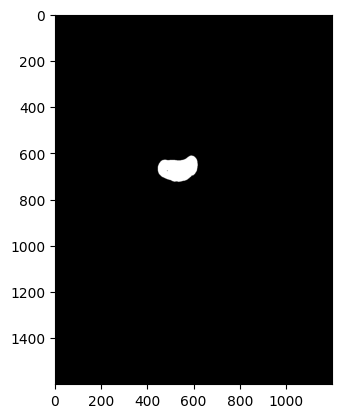

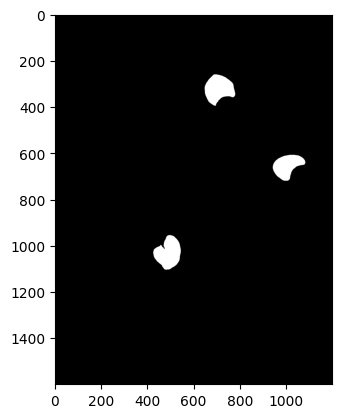

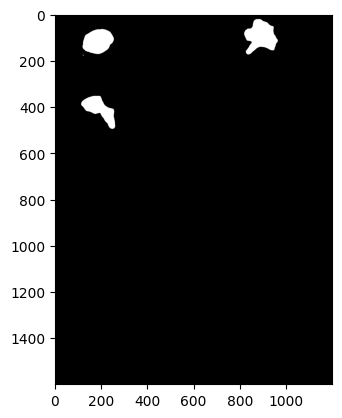

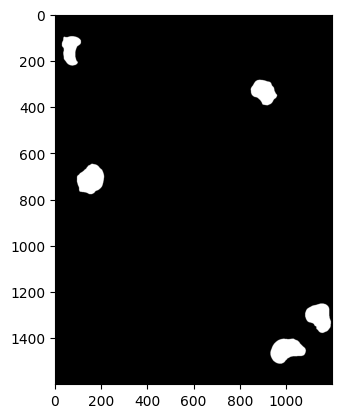

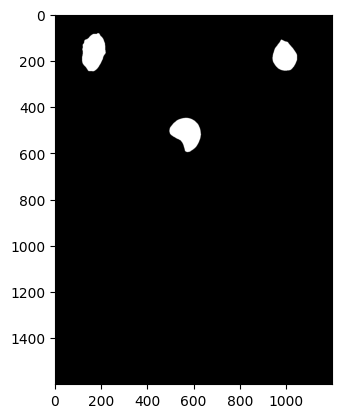

In [165]:
for i in batch_segments:
    plt.imshow(np.transpose(batch_segments[i]["segmentation"],(2,1,0)), cmap='gray')
    plt.show()


Path for Saving folder

/content/drive/MyDrive/Malaria_Cell_SAM